In [1]:
# Environment necessary to run code is defined in BEE/package_requierements.txt
import sys, os
import numpy as np
import pandas as pd
import torch
import pkg_resources
import collections
import json, time, timeit

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split

sys.path.insert(0, "../../BEE")
sys.path.insert(0, "../reaction_transformers")
import reaction_transformers
from reaction_transformers.models import SmilesLanguageModelingModel
from reaction_transformers.models import SmilesClassificationModel
from reaction_transformers.conditions_encoding import ConditionIDEncoder
from reaction_transformers.tokenization import smi_tokenizer

from reaction_transformers.input_output_processing import split_data, convert_strlst2lstfloat, replace_sep, add_photocat_react_ids, nested_cross_validation, \
                                                          epochs_calc_r2, r2score_stats, save_ncv_testresults

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
#Both the pretraining and finetuning code expects these parameters to be defined
#These should be user defined depending on use case and dataset

PRECURSOR_MODEL_NAME = "usptoep20"
ENRICHMENT_VOCAB_SIZE = 16

#Use of enrichment in precursor model is not a requierement for its use in finetuning
ENRICHMENT_THRESHOLDS = [0.02, 0.05, 0.5, 5, 100, 150, 180, 1000]
ID2ROLE = {"1": "aryl_halides", "2":"solvent", "3": "photocalysts", "4": "piperidines", "5":"catalysts", "6":"ni_catalysts"}

## MLM training with USPTO 2020

In [3]:
#Cell used to create the train and test .txt files
uspto_csv_path = "../data/USPTO_cleaned_1.38M.csv"
train_file_path = '../data/uspto_train.txt'
eval_file_path = '../data/uspto_test.txt'

assert (os.path.exists(train_file_path) and  os.path.exists(eval_file_path)), \
"uspto_train.txt and/or uspto_test.txt not were found in the data folder. uspto_train_test.zip must be unzipped."

if os.path.exists(uspto_csv_path) and not(os.path.exists(train_file_path)):
    df_uspto = pd.read_csv(uspto_csv_path)
    df_uspto = df_uspto[~df_uspto.smiles.isna()]
    df_uspto = df_uspto.sample(frac=1, random_state = 42)

    print(f"The total number of reactions in this USPTO dataset is {len(df_uspto)}.")

    with open(train_file_path,'w') as f:
        f.write('\n'.join(df_uspto.smiles.values[:int(len(df_uspto)*0.85)]))
    with open(eval_file_path,'w') as f:
        f.write('\n'.join(df_uspto.smiles.values[int(len(df_uspto)*0.85):]))


In [4]:
#equivalents_vocab_size should be defined according to the number of classes that will encode additional condition information in the pretraining and/or finetuning
#even if the pretaining data doesn't have any additional condition classes, a value should be set accounting for input data in the finetuning

config = {
  "architectures": ["BertForMaskedLM"],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "Bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "equivalents_vocab_size": ENRICHMENT_VOCAB_SIZE
}
vocab_path = f"../reaction_transformers/pretrained_models/transformers/bert_{PRECURSOR_MODEL_NAME}/vocab.txt"
args = {'config': config, 
        'vocab_path': vocab_path, 
        'train_batch_size': 2*32,
        'manual_seed': 42,
        "fp16": False,
        "num_train_epochs": 30,
        'max_seq_length': 550,
        'evaluate_during_training': False,
        'overwrite_output_dir': True,
        'output_dir': f'../reaction_transformers/pretrained_models/transformers/bert_{PRECURSOR_MODEL_NAME}',
        'learning_rate': 2*1e-4,
        'n_gpu': 1
       }

model = SmilesLanguageModelingModel(model_type='bert', model_name=None, args=args)

model.train_model(train_file=train_file, eval_file=eval_file, show_running_loss = False)

#### Code to prepare finetuning data for regression task

In [7]:
def load_prepare_data(data_path, CondIDEnc):
    """
    Load .csv into dataframe and process data into ML ready format
    """
    df_photoredox = pd.read_csv(data_path + "/Photoredox_rxns.csv", index_col = 0)
    
    #Adding a high moles value to solvent such that resulting class wont overlap with other enrichment embedding classes 
    df_photoredox["solvent_moles"] = 1000

    #notebook expects data to be standardized (rdkit canonical sorted) with reactant_ids ready
    df_photoredox["reactant_ids_order"] = df_photoredox.progress_apply(lambda row: convert_strlst2lstfloat(row["reactant_ids_order"]), axis = 1)
    #this line is only necessary if reactant ids associated with the photocatalyst are missing
    df_photoredox["reactant_ids_order"] = df_photoredox.progress_apply(lambda row: add_photocat_react_ids(row, ID2ROLE), axis = 1)
    df_photoredox["reactant_moles"] = df_photoredox.progress_apply(lambda row: CondIDEnc.convert_reactant_id_2_moles(row), axis = 1)

    df_photoredox["enrichment_class"] = df_photoredox.reactant_moles.progress_apply(lambda reactant_moles: CondIDEnc.convert_conditions2class(reactant_moles))

    df_photoredox["reaction_smiles_sep"] = df_photoredox.apply(lambda row: replace_sep(row), axis = 1)
    df_photoredox["equivalents"] = df_photoredox.progress_apply(lambda row: CondIDEnc.generate_equivalents_vector(row), axis = 1)
    df_photoredox["equivalents_vector_size"] = df_photoredox.equivalents.apply(lambda eqvs_vec: len(eqvs_vec))

    #sanity check
    df_photoredox["reaction_smiles_size"] = df_photoredox["reaction_smiles_std"].apply(lambda react_smiles: len(smi_tokenizer(react_smiles).split(" ")))
    assert df_photoredox['reaction_smiles_size'].equals(df_photoredox['equivalents_vector_size'])

    df_photoredox["labels"] = df_photoredox['uplcms'].apply(lambda uplcms: uplcms/100)
    
    #Column with chython standardized smiles or sorted rdkit canonical smiles
    df_photoredox.rename(columns={"reaction_smiles_std":"text"}, inplace = True)

    df_photoredox = df_photoredox.sample(frac = 1, random_state = 42)

    return df_photoredox

## Running USPTO BERT enriched vs not enriched on PhotoRedox 1700

In [5]:
data_path = '../data'
num_splits = 5
CondIDEnc = ConditionIDEncoder(PRECURSOR_MODEL_NAME, ENRICHMENT_THRESHOLDS, ID2ROLE)

In [ ]:
%%capture

#Photoredox data used in this notebook is donominated "Informer Library" and was derived from a publication from Scientists at Merck    
df_photoredox = load_prepare_data(data_path, CondIDEnc)

#Finetuning USPTO BERT in 5 different splits with equivalent information
col_interest = ["text","labels","equivalents"]
nested_cross_validation(df_photoredox, col_interest, num_splits, PRECURSOR_MODEL_NAME)

#Finetuning USPTO BERT in 5 different splits without equivalent information
col_interest = ["text","labels"]
nested_cross_validation(df_photoredox, col_interest, num_splits, PRECURSOR_MODEL_NAME)

In [4]:
%%capture

df_photoredox = load_prepare_data(data_path, CondIDEnc)

#Testing and saving results of finetuned USPTO BERT with enriched embedding
col_interest = ["text","labels","equivalents"]
save_ncv_testresults(df_photoredox, col_interest, num_splits, PRECURSOR_MODEL_NAME)

#Testing and saving results of finetuned USPTO BERT without enriched embedding
col_interest = ["text","labels"]
save_ncv_testresults(df_photoredox, col_interest, num_splits, PRECURSOR_MODEL_NAME)

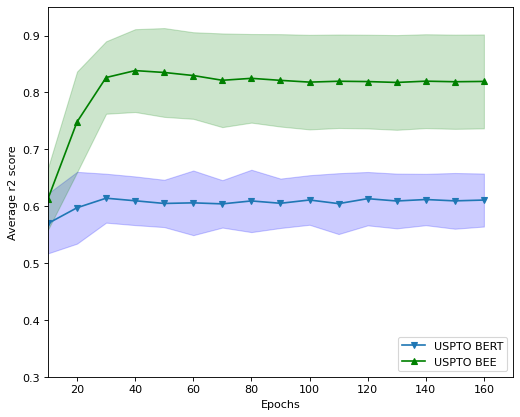

In [8]:
from matplotlib.pyplot import figure

figure(figsize=(7.5, 6), dpi=80)

with open (f"../results/{PRECURSOR_MODEL_NAME}_photoredox_ncv_NOeqvs_results.json", "r") as json_data:
    r2_scores_all_BEE = json.loads(json_data.read())

r2_bee_all_avg, r2_bee_all_min, r2_bee_all_max, r2_bee_all_std = r2score_stats(r2_scores_all_BEE[1])

epochs = [int(ep.split("_")[1]) for ep in list(r2_scores_all_BEE[1]["ncv_0"].keys())]
plt.plot(epochs, r2_bee_all_avg, marker='v', label = "USPTO BERT")
plt.fill_between(epochs, [i-j for i,j in zip(r2_bee_all_avg,r2_bee_all_std)], [i+j for i,j in zip(r2_bee_all_avg,r2_bee_all_std)], color='blue', alpha=0.2)


with open (f"../results/{PRECURSOR_MODEL_NAME}_photoredox_ncv_eqvs_results.json", "r") as json_data:
    r2_scores_all_BEE = json.loads(json_data.read())

r2_bee_all_avg, r2_bee_all_min, r2_bee_all_max, r2_bee_all_std = r2score_stats(r2_scores_all_BEE[1])

epochs = [int(ep.split("_")[1]) for ep in list(r2_scores_all_BEE[1]["ncv_0"].keys())]
plt.plot(epochs, r2_bee_all_avg, color='green', marker='^', label = "USPTO BEE")
plt.fill_between(epochs, [i-j for i,j in zip(r2_bee_all_avg,r2_bee_all_std)], [i+j for i,j in zip(r2_bee_all_avg,r2_bee_all_std)], color='green', alpha=0.2)

plt.xlim(10,170)
plt.ylim(0.3,0.95)
#plt.title("Performance Comparison on Regression Task")
plt.xlabel("Epochs")
plt.ylabel("Average r2 score")
plt.legend(loc = 'lower right')
plt.show()

### Measuring Average time of an inference operation

In [5]:
df_photoredox = load_prepare_data(data_path)
df_photoredox= pd.concat([df_photoredox]*5)

model_dir = f"../fine_tuned_models/{PRECURSOR_MODEL_NAME}_photoredox_eqvs_ncv_0"
checkpoit_multiple=22
epoch = 160

model_path = model_dir + f"/checkpoint-{epoch*checkpoit_multiple}-epoch-{epoch}"
trained_yield_bert = SmilesClassificationModel('bert', model_path, num_labels=1, args={"regression": True}, use_cuda=torch.cuda.is_available())
if "equivalents" in df_photoredox.columns:
    print("Equivalents used.")
    t1 = time.time()
    lcms_predicted = trained_yield_bert.predict(df_photoredox.text.values, equivalents = df_photoredox.equivalents.values)[0]
    t2 = time.time()
print(f"Model made {round(len(df_photoredox)/(t2-t1),2)} complete inference operations per second.")

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

[W 2022-10-05 10:10:19,772.772 utilities.tokenization_utils] Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
[W 2022-10-05 10:10:19,773.773 utilities.tokenization_utils] Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


Equivalents used.


100%|██████████| 1080/1080 [00:09<00:00, 116.95it/s]

Model made 608.92 complete inference operations per second.


In [6]:
!nvidia-smi

Wed Oct  5 10:15:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:0F:00.0 Off |                    0 |
| N/A   30C    P0    57W / 400W |   1996MiB / 40537MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------